In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import pickle, json
import numpy as np

import pandas as pd

In [2]:
model_type = "conversation" # abc or conversation

In [3]:
device = "mps"

In [4]:
with open(f"../data/clean/{model_type}_train.pkl", "rb") as f:
    train = pickle.load(f)

with open(f"../data/clean/{model_type}_test.pkl", "rb") as f:
    test = pickle.load(f)

train_tensors = []
for i in train:
    train_tensors.append({
        "data": torch.tensor(i["data"]).float(),
        "label": torch.tensor(i["label"]).long()
    })

test_tensors = []
for i in test:
    test_tensors.append({
        "data": torch.tensor(i["data"]).float(),
        "label": torch.tensor(i["label"]).long()
    })

train_loader = DataLoader(train_tensors, batch_size=32, shuffle=True)
test_loader = DataLoader(test_tensors, batch_size=32, shuffle=True)

In [5]:
with open(f"../model/{model_type}_id2label.pkl", "rb") as f:
    id2label = pickle.load(f)

id2label

{0: 'yes',
 1: 'no',
 2: 'hello',
 3: 'bye',
 4: 'how',
 5: 'old',
 6: 'why',
 7: 'you',
 8: 'me',
 9: 'explore',
 10: 'deaf',
 11: 'easter_egg'}

In [6]:
from PointNet import train_model, PointNet, eval_model

num_classes = len(id2label)
print(f"Instantiating model with {num_classes} classes")
pointnet = PointNet(classes=num_classes, device=device)
pointnet.to(device)

Instantiating model with 12 classes


PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [7]:
checkpoint_path = f"../model/{model_type}.pth"
train_model(pointnet, train_loader, test_loader, checkpoint_path, epochs=18, device=device)

[Epoch: 1, Batch:   16 /   45], loss: 2.964
[Epoch: 1, Batch:   32 /   45], loss: 1.879
Valid accuracy: 75 %
[Epoch: 2, Batch:   16 /   45], loss: 0.744
[Epoch: 2, Batch:   32 /   45], loss: 0.599
Valid accuracy: 91 %
[Epoch: 3, Batch:   16 /   45], loss: 0.503
[Epoch: 3, Batch:   32 /   45], loss: 0.431
Valid accuracy: 92 %
[Epoch: 4, Batch:   16 /   45], loss: 0.383
[Epoch: 4, Batch:   32 /   45], loss: 0.312
Valid accuracy: 98 %
[Epoch: 5, Batch:   16 /   45], loss: 0.311
[Epoch: 5, Batch:   32 /   45], loss: 0.323
Valid accuracy: 96 %
[Epoch: 6, Batch:   16 /   45], loss: 0.260
[Epoch: 6, Batch:   32 /   45], loss: 0.215
Valid accuracy: 96 %
[Epoch: 7, Batch:   16 /   45], loss: 0.202
[Epoch: 7, Batch:   32 /   45], loss: 0.243
Valid accuracy: 98 %
[Epoch: 8, Batch:   16 /   45], loss: 0.201
[Epoch: 8, Batch:   32 /   45], loss: 0.247
Valid accuracy: 98 %
[Epoch: 9, Batch:   16 /   45], loss: 0.149
[Epoch: 9, Batch:   32 /   45], loss: 0.204
Valid accuracy: 98 %
[Epoch: 10, Batch: 

Batch [   1 /   30]
Batch [   2 /   30]
Batch [   3 /   30]
Batch [   4 /   30]
Batch [   5 /   30]
Batch [   6 /   30]
Batch [   7 /   30]
Batch [   8 /   30]
Batch [   9 /   30]
Batch [  10 /   30]
Batch [  11 /   30]
Batch [  12 /   30]
Batch [  13 /   30]
Batch [  14 /   30]
Batch [  15 /   30]
Batch [  16 /   30]
Batch [  17 /   30]
Batch [  18 /   30]
Batch [  19 /   30]
Batch [  20 /   30]
Batch [  21 /   30]
Batch [  22 /   30]
Batch [  23 /   30]
Batch [  24 /   30]
Batch [  25 /   30]
Batch [  26 /   30]
Batch [  27 /   30]
Batch [  28 /   30]
Batch [  29 /   30]
Batch [  30 /   30]
Normalized confusion matrix


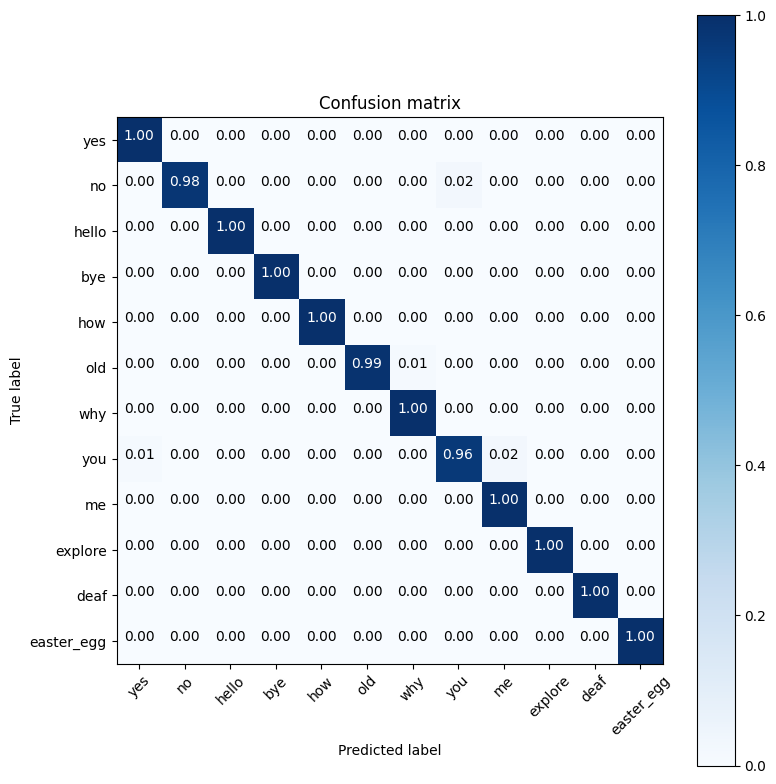

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

pointnet = PointNet(classes=num_classes, device="cpu")
pointnet.load_from_pth(checkpoint_path)

pointnet.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        print('Batch [%4d / %4d]' % (i+1, len(test_loader)))
        
        inputs, labels = data['data'], data['label']
        inputs, labels = inputs.float(), labels.long()

        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
cm = confusion_matrix(all_labels, all_preds)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(id2label.values()), normalize=True)